#Biased Quantum Galton Board: Simulating Probability Distributions

This notebook implements a `biased quantum circuit`—an extension of the Quantum Galton board that allows for adjustable probability distributions at each branching point. Unlike the unbiased circuit, which ensures equal probabilities and always produces a normal distribution, the biased version replaces Hadamard gates with `quantum rotation gates` $R_x(Θ)$, making it possible to tune each node’s bias and thus create a variety of `output distributions`, not just the normal. This flexible biasing is essential for modelling both standard and `non-Gaussian statistical processes`, enabling the quantum Galton board to act as a versatile simulator for a wide class of stochastic phenomena.

## Setup and Installation

To run the quantum circuit simulation and related analyses in this notebook, ensure you have the required `Python packages` installed.

In [7]:
!qiskit_aer --version

/bin/bash: line 1: qiskit_aer: command not found


In [2]:
!pip install numpy scipy qiskit qiskit qiskit_aer matplotlib pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b54aa6dcd12b528f85a33d30ab8bb7146b6efbb1f80df52deeb78f09bf8b8c78
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [5]:
import collections
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from scipy.stats import norm

##Functions

###Quantum Walk Step: One Peg Galton Board

In [ ]:
def one_peg_galton_board(
    qc: QuantumCircuit,
    control_qubit: QuantumRegister,
    target_q_reg: QuantumRegister,
    center_idx: int,
    j: int,
    is_last_step: bool
):
    """
    Applies one step of the controlled-swaps sequence which illustrates one peg in a certain level forms the core of the
    quantum wala. This function encapsulates the four-gate sequence

    Args:
        qc: The QuantumCircuit to add gates to.
        control_qubit: The qubit controlling the operations.
        target_q_reg: The register on which the walk occurs.
        center_idx: The index of the center qubit in target_q_reg.
        j: The offset from the center for the current step.
        is_last_step: A boolean to prevent adding a final CNOT.
    """
    # Define the three qubits involved in this step
    qubit_A = target_q_reg[center_idx + j - 1]
    qubit_B = target_q_reg[center_idx + j]
    qubit_C = target_q_reg[center_idx + j + 1]

    # The Quantum circuit for 1 peg step
    qc.cswap(control_qubit, qubit_A, qubit_B)
    qc.cx(qubit_B, control_qubit)
    qc.cswap(control_qubit, qubit_B, qubit_C)

    # The final CNOT is omitted on the last step of the inner loop for optimization purpose
    if not is_last_step:
        qc.cx(qubit_C, control_qubit)

###Biased Galton Board Circuit

In [ ]:
def biased_Galton_board_circuit(level: int,Controls : list) -> QuantumCircuit:
    """
    Builds the complete quantum galton board circuit in a structured and modular way.

    Args:
        level: No. of levels in Galton board
        Controls: List of value of theta of each level

    Returns:
        The fully constructed Quantum Galton Board Circuit object.
    """
    # Check if the number of control angles matches the number of levels
    if len(Controls)!=level:
        raise ValueError("Not optimal Control")

    # 1. SETUP: Define quantum and classical registers
    num_qubits = 2 * (level + 1) # Number of qubits needed for the walk space
    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(level + 1, "c")
    circuit = QuantumCircuit(q, c) # Create the quantum circuit

    # Define key qubit indices
    control_qubit = q[0]
    center_qubit_index = level + 1 # This is the starting position index

    # 2. INITIAL STATE: Prepare the system
    '''Set the qubit at the center_qubit_index to the |1> state.This initializes the walk at the central
      position in the quantum walk space'''

    circuit.x(q[center_qubit_index])

    # 3. ALGORITHM: Build the main logic of the circuit
    for i in range(level):
        circuit.reset(control_qubit)
        circuit.rx(Controls[i],control_qubit)
        indices = list(range(-i, i+1, 2))
        '''Get list of relative position of individual peg circuit relative to center qubit for a particular value of i(level)
           Example:
          - i=0 -> [0]
          - i=1 -> [-1, 1]
          - i=2 -> [-2, 0, 2]
          - i=3 -> [-3,-1,1,3]'''
        # Apply the quantum walk step (one peg operation) for each relevant position in the current level
        for step_index, j in enumerate(indices):
            # Check if this is the last step in the inner loop for optimization
            is_last = (step_index == len(indices) - 1)
            one_peg_galton_board(
                qc=circuit,
                control_qubit=control_qubit,
                target_q_reg=q,
                center_idx=center_qubit_index,
                j=j,
                is_last_step=is_last
            )
    circuit.barrier()

    # 4. MEASUREMENT: Measure the desired qubits to get the result
    qubits_to_measure = [q[i] for i in range(num_qubits) if i % 2 != 0]
    circuit.measure(qubits_to_measure, c) # Measure the selected qubits into the classical register

    return circuit

###Finding $θ_j$ For a Target Distribution

This function solves an `inverse problem` for a biased Galton board (or quantum-inspired binomial process) where each peg $j$ deflects right with probability $p_j = \cos^2\left( \frac{\theta_j}{2} \right)$. Starting with all probability at $k=0$ right-turns, the overall output distribution is built via iterative Bernoulli convolutions, and the peg angles ${\theta_j}$ are chosen so that this model distribution matches a target distribution in a least-squares sense.

The probability formula comes from the quantum $R_x(\theta)$ rotation, where the amplitude for the $|0\rangle$ outcome is $\cos(\theta/2)$.  Using the `L-BFGS-B` optimizer with bounds $[0,\pi]$, the code finds the optimal set of angles that reproduce the desired output histogram.

In [ ]:
def find_theta_values(target_probs):
    """
    Find theta values for each peg so that the resulting distribution matches
    a given target probability distribution.

    Parameters:
        target_probs: Target probability distribution for k=0,...,levels right turns.
    Returns:
        list of float: Optimal theta values in radians.
    """
    target_probs = np.array(target_probs, dtype=float)
    target_probs /= target_probs.sum()  # Normalize

    levels = len(target_probs) - 1  # number of pegs

    # Each peg's right probability: p_j = cos^2(theta_j / 2)
    def computed_distribution(thetas):
        p = np.cos(np.array(thetas) / 2) ** 2
        dist = np.array([1.0])
        for prob in p:
            dist = np.convolve(dist, [1 - prob, prob])
        return np.sum((dist - target_probs) ** 2)

    # Initial guess & bounds
    initial = np.full(levels, np.pi / 2)
    bounds = [(0, np.pi) for _ in range(levels)]

    # Optimize
    result = minimize(computed_distribution, initial, bounds=bounds, method='L-BFGS-B')

    if result.success:
        return result.x.tolist()
    else:
        raise RuntimeError("Optimization failed to converge")


##Simulation and Visulisation

###Exponential distribution

In [ ]:
def exponential_distribution(x:np.ndarray, lambda_:int):
  return lambda_ * np.exp(-lambda_ * x)

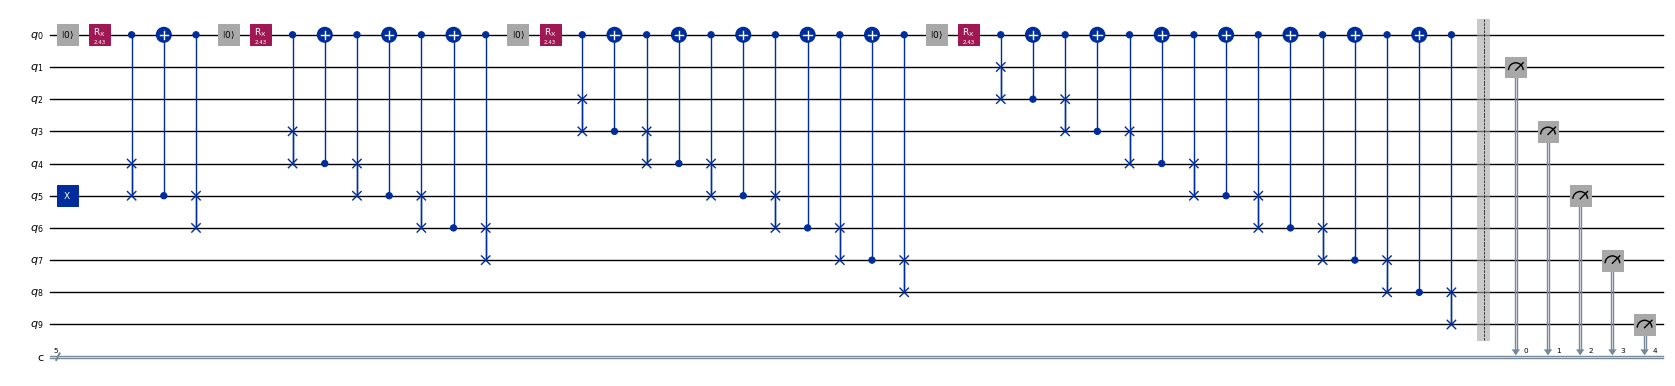

In [ ]:
circuit_level = 4
k = np.arange(circuit_level + 1)
lam = 0.82
target_probs = exponential_distribution(k,lam)
circuit_controls= find_theta_values(target_probs)

# Build the circuit
my_circuit = biased_Galton_board_circuit(level=circuit_level,Controls=circuit_controls)
my_circuit.draw('mpl',scale=0.5,fold=100)

Measurement counts (no noise): {'01000': 12, '10000': 2, '00100': 139, '00010': 680, '00001': 1215}


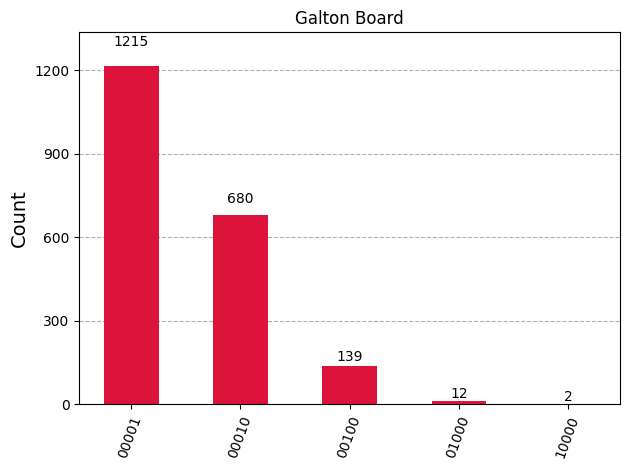

In [ ]:
# 2. Execute simulation on the Aer simulator (ideal, noiseless)
sim = AerSimulator()
result = sim.run(my_circuit, shots=2048).result()
counts = result.get_counts()

# 3. Display results as a histogram
print("Measurement counts (no noise):", counts)
plot_histogram(counts, bar_labels=True, color=['crimson'],title="Galton Board")

###Hadamard quantum walk

In [ ]:
def Hadamard_quantum_walk(k):
  return [np.pi/2] * (k) #Hadamard Gate

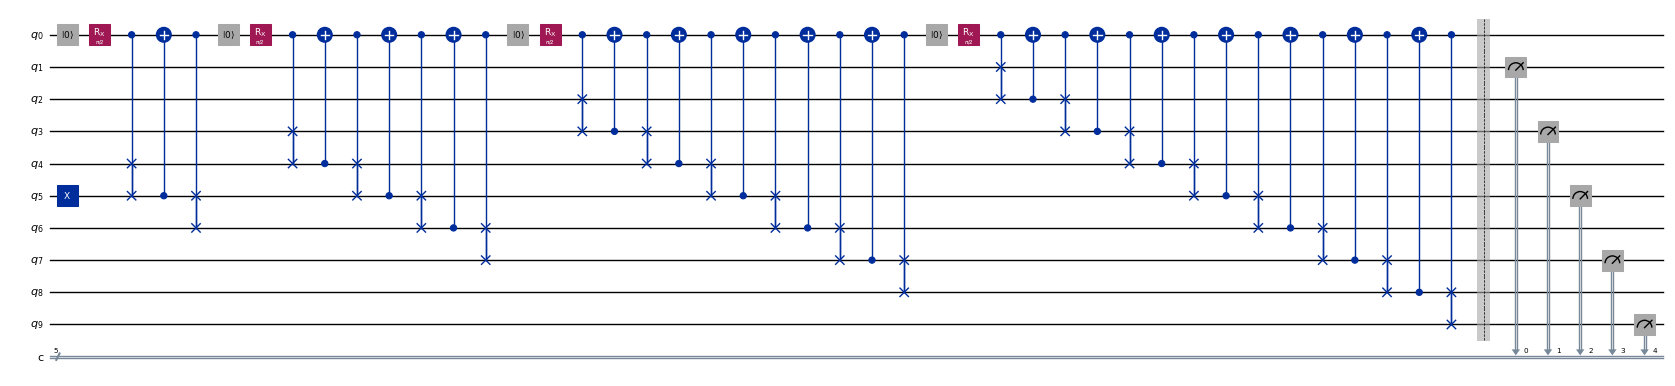

In [ ]:
circuit_level = 4
circuit_controls= Hadamard_quantum_walk(circuit_level)

# Build the circuit
my_circuit = biased_Galton_board_circuit(level=circuit_level,Controls=circuit_controls)
my_circuit.draw('mpl',scale=0.5,fold=100)

Measurement counts (no noise): {'00001': 130, '01000': 512, '10000': 132, '00100': 720, '00010': 506}


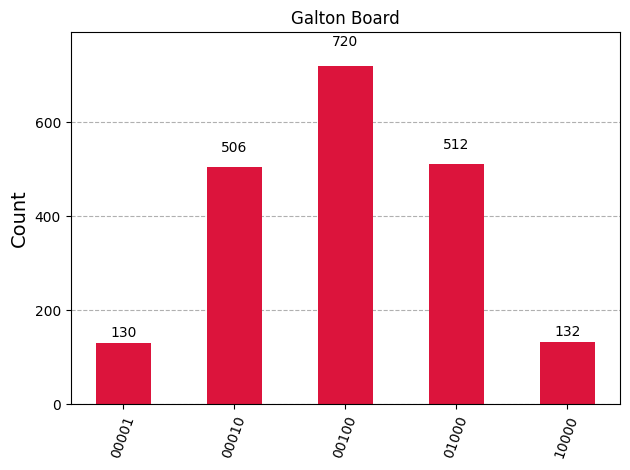

In [ ]:
# 2. Execute simulation on the Aer simulator (ideal, noiseless)
sim = AerSimulator()
result = sim.run(my_circuit, shots=2048).result()
counts = result.get_counts()

# 3. Display results as a histogram
print("Measurement counts (no noise):", counts)
plot_histogram(counts, bar_labels=True, color=['crimson'],title="Galton Board")